# EEWS dengan Seisbench Models


## Import Libraries

In [ ]:
!pip install seisbench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.2/167.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [ ]:
import seisbench
import seisbench.util as sbu
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pathlib import Path

## Getting Data from OBSpy

In [ ]:
client = Client("GEOFON")

In [ ]:
import numpy as np
import tensorflow as tf
import keras

print("Numpy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


Numpy version: 1.25.2
TensorFlow version: 2.15.0
Keras version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle


def load_catalogs_from_drive(filename):
    # Path to load the file from Google Drive
    filepath = f'/content/drive/My Drive/EEWS/{filename}.pkl'
    with open(filepath, 'rb') as f:
        catalogs = pickle.load(f)
    return catalogs


Mounted at /content/drive


In [ ]:
# Load the catalogs
low_magnitude_catalogs = load_catalogs_from_drive('low_magnitude_catalogs')
mid_magnitude_catalogs = load_catalogs_from_drive('mid_magnitude_catalogs')
high_magnitude_catalogs = load_catalogs_from_drive('high_magnitude_catalogs')
low_magnitude_s_phase_catalogs = load_catalogs_from_drive('low_magnitude_s_phase_catalogs')
mid_magnitude_s_phase_catalogs = load_catalogs_from_drive('mid_magnitude_s_phase_catalogs')
high_magnitude_s_phase_catalogs = load_catalogs_from_drive('high_magnitude_s_phase_catalogs')

# Unpack the loaded catalogs into separate variables
low_magnitude_catalog, low_param_catalog, selected_low_event_catalog, low_event_params = low_magnitude_catalogs
mid_magnitude_catalog, mid_param_catalog, selected_mid_magnitude_event_catalog, mid_event_params = mid_magnitude_catalogs
high_magnitude_catalog, high_param_catalog, selected_high_magnitude_event_catalog, high_event_params = high_magnitude_catalogs
low_magnitude_s_phase_catalog, low_param_s_phase_catalog, selected_low_magnitude_s_event_catalog, low_s_event_params = low_magnitude_s_phase_catalogs
mid_magnitude_s_phase_catalog, mid_param_s_phase_catalog, selected_mid_magnitude_s_event_catalog, mid_s_event_params = mid_magnitude_s_phase_catalogs
high_magnitude_s_phase_catalog, high_param_s_phase_catalog, selected_high_magnitude_s_event_catalog, high_s_event_params = high_magnitude_s_phase_catalogs

# Combine the catalogs
combined_low_magnitude_catalog = low_magnitude_catalog + low_magnitude_s_phase_catalog
combined_low_param_catalog = low_param_catalog + low_param_s_phase_catalog
combined_selected_low_event_catalog = selected_low_event_catalog + selected_low_magnitude_s_event_catalog
combined_low_event_params = low_event_params + low_s_event_params

combined_mid_magnitude_catalog = mid_magnitude_catalog + mid_magnitude_s_phase_catalog
combined_mid_param_catalog = mid_param_catalog + mid_param_s_phase_catalog
combined_selected_mid_event_catalog = selected_mid_magnitude_event_catalog + selected_mid_magnitude_s_event_catalog
combined_mid_event_params = mid_event_params + mid_s_event_params

combined_high_magnitude_catalog = high_magnitude_catalog + high_magnitude_s_phase_catalog
combined_high_param_catalog = high_param_catalog + high_param_s_phase_catalog
combined_selected_high_event_catalog = selected_high_magnitude_event_catalog + selected_high_magnitude_s_event_catalog
combined_high_event_params = high_event_params + high_s_event_params



In [ ]:
def resample_catalog(catalog, new_sampling_rate):
    for event in catalog:
        for pick in event:
            for trace in pick:
                if trace.stats.sampling_rate != new_sampling_rate:
                    trace.resample(sampling_rate=new_sampling_rate)

In [ ]:
import copy

# Make copies of the combined catalogs
combined_low_magnitude_catalog_copy = copy.deepcopy(combined_low_magnitude_catalog)
combined_mid_magnitude_catalog_copy = copy.deepcopy(combined_mid_magnitude_catalog)
combined_high_magnitude_catalog_copy = copy.deepcopy(combined_high_magnitude_catalog)

# Desired new sampling rate
new_sampling_rate = 100.0

# Resample the copied catalogs
resample_catalog(combined_low_magnitude_catalog_copy, new_sampling_rate)
resample_catalog(combined_mid_magnitude_catalog_copy, new_sampling_rate)
resample_catalog(combined_high_magnitude_catalog_copy, new_sampling_rate)

In [ ]:
print(len(combined_low_magnitude_catalog_copy))
print(len(combined_mid_magnitude_catalog_copy))
print(len(combined_high_magnitude_catalog_copy))

21
131
48


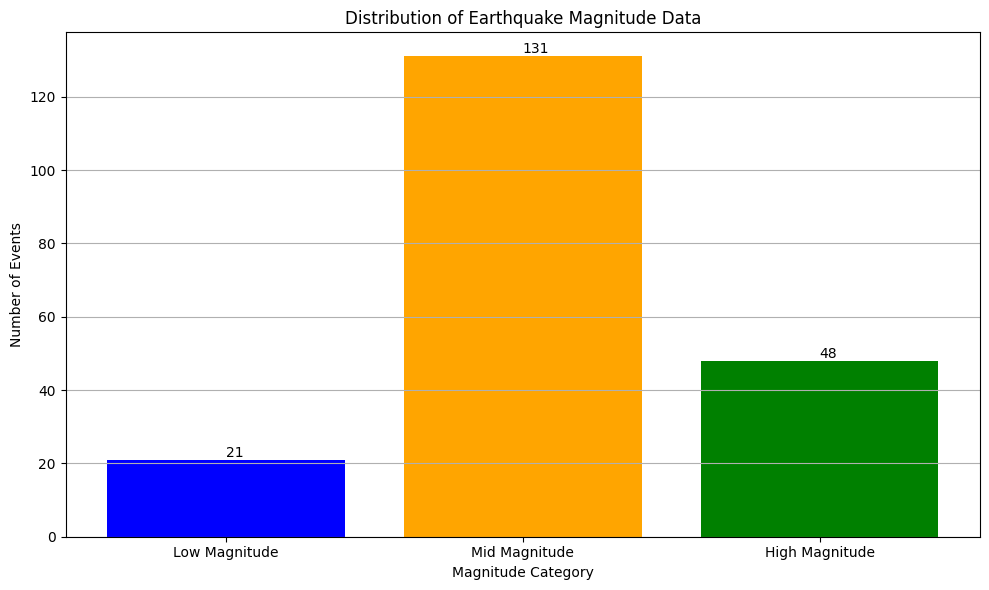

In [ ]:
# Example data lengths (replace these with the actual lengths)
combined_low_magnitude_catalog_length = len(combined_low_magnitude_catalog)
combined_mid_magnitude_catalog_length = len(combined_mid_magnitude_catalog)
combined_high_magnitude_catalog_length = len(combined_high_magnitude_catalog)

# Data for the bar chart
categories = ['Low Magnitude', 'Mid Magnitude', 'High Magnitude']
counts = [combined_low_magnitude_catalog_length, combined_mid_magnitude_catalog_length, combined_high_magnitude_catalog_length]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['blue', 'orange', 'green'])

# Adding the numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.title('Distribution of Earthquake Magnitude Data')
plt.xlabel('Magnitude Category')
plt.ylabel('Number of Events')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
print(low_param_s_phase_catalog)

[[{'station_network_code': 'GE', 'station_code': 'TOLI2', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2017-10-12T10:09:24.269538Z', 'trace_P_arrival_time': '2017-10-12T10:10:24.260000Z', 'trace_P_arrival_sample': 1199, 'trace_P_status': 'automatic'}, {'station_network_code': 'GE', 'station_code': 'LUWI', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2017-10-12T10:09:25.569538Z', 'trace_P_arrival_time': '2017-10-12T10:10:25.560000Z', 'trace_P_arrival_sample': 1199, 'trace_P_status': 'automatic'}, {'station_network_code': 'GE', 'station_code': 'SANI', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2017-10-12T10:09:58.919536Z', 'trace_P_arrival_time': '2017-10-12T10:10:58.940000Z', 'trace_P_arrival_sample': 1200, 'trace_P_status': 'manual'}, {'station_network_code': 'GE', 'station_code': 'BBJI', 'trace_chann

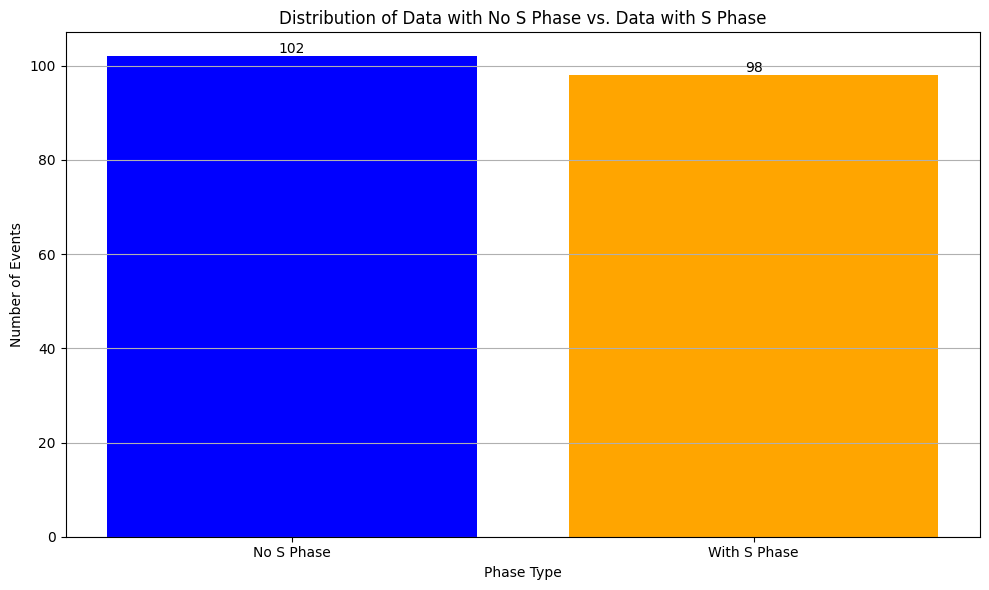

In [ ]:
# Example data (replace these with the actual counts)
non_s_count = (
    len(low_magnitude_catalog) +
    len(mid_magnitude_catalog) +
    len(high_magnitude_catalog)
)

s_count = (
    len(low_magnitude_s_phase_catalog) +
    len(mid_magnitude_s_phase_catalog) +
    len(high_magnitude_s_phase_catalog)
)

# Data for the bar chart
categories = ['No S Phase', 'With S Phase']
counts = [non_s_count, s_count]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['blue', 'orange'])

# Adding the numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va='bottom', ha='center')  # va: vertical alignment

plt.title('Distribution of Data with No S Phase vs. Data with S Phase')
plt.xlabel('Phase Type')
plt.ylabel('Number of Events')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Sample data Low
predictions_low = [
    {'latitude': -6.4821, 'longitude': 130.1450, 'magnitude': 4.9, 'origin_id': 'gfz2016eslv', 'depth': 80.8},
    {'latitude': -6.7457, 'longitude': 127.5214, 'magnitude': 4.3, 'origin_id': 'gfz2023crad', 'depth': 368},
    {'latitude': 0.4107, 'longitude': 122.0864, 'magnitude': 4.2, 'origin_id': 'gfz2017tzqz', 'depth': 211},
    {'latitude': -7.3196, 'longitude': 120.2524, 'magnitude': 4.2, 'origin_id': 'gfz2018agtg', 'depth': 531},
    {'latitude': -6.8577, 'longitude': 127.2694, 'magnitude': 4.6, 'origin_id': 'gfz2022zawq', 'depth': 439},
]

ground_truth_low = [
    {'latitude': -6.5540, 'longitude': 130.1450, 'magnitude': 4.4, 'depth': 110.8},
    {'latitude': -6.644, 'longitude': 127.52, 'magnitude': 4.4, 'depth': 398},
    {'latitude': 0.3090, 'longitude': 122.0850, 'magnitude': 4.0, 'depth': 181},
    {'latitude': -7.3210, 'longitude': 120.3550, 'magnitude': 4.0, 'depth': 559},
    {'latitude': -6.8580, 'longitude': 127.2950, 'magnitude': 4.4, 'depth': 409},
]
# Sample data Mid
predictions_mid = [
    {'latitude': 1.5215, 'longitude': 127.2320, 'magnitude': 4.8, 'depth': 166.0, 'origin_id': 'gfz2016biot'},
    {'latitude': 4.3447, 'longitude': 127.5516, 'magnitude': 4.4, 'depth': 83.0, 'origin_id': 'gfz2016arku'},
    {'latitude': -3.2906, 'longitude': 102.7361, 'magnitude': 4.5, 'depth': 168.0, 'origin_id': 'gfz2016aqjd'},
    {'latitude': -9.2949, 'longitude': 117.7235, 'magnitude': 5.0, 'depth': 72.0, 'origin_id': 'gfz2016aomu'},
    {'latitude': 0.8776, 'longitude': 122.5426, 'magnitude': 4.2, 'depth': 48.0, 'origin_id': 'gfz2016amea'},
    {'latitude': -7.3763, 'longitude': 119.9314, 'magnitude': 4.1, 'depth': 580.0, 'origin_id': 'gfz2016akak'},
    {'latitude': -5.9401, 'longitude': 130.6780, 'magnitude': 5.0, 'depth': 113.0, 'origin_id': 'gfz2016ahsw'},
    {'latitude': -6.2356, 'longitude': 103.6837, 'magnitude': 4.2, 'depth': 40.0, 'origin_id': 'gfz2016ahcg'},
    {'latitude': -6.2719, 'longitude': 130.4040, 'magnitude': 4.1, 'depth': 116.0, 'origin_id': 'gfz2016adcc'}
]

ground_truth_mid = [
    {'latitude': 1.5200, 'longitude': 127.3220, 'magnitude': 4.9, 'depth': 152.0},
    {'latitude': 4.3430, 'longitude': 127.6260, 'magnitude': 5.0, 'depth': 113.0},
    {'latitude': -3.2920, 'longitude': 102.8380, 'magnitude': 4.4, 'depth': 198.0},
    {'latitude': -9.2050, 'longitude': 117.7220, 'magnitude': 5.3, 'depth': 94.0},
    {'latitude': 0.9580, 'longitude': 122.5410, 'magnitude': 4.7, 'depth': 56.0},
    {'latitude': -7.4780, 'longitude': 119.9300, 'magnitude': 4.6, 'depth': 610.0},
    {'latitude': -6.0300, 'longitude': 130.6770, 'magnitude': 5.4, 'depth': 143.0},
    {'latitude': -6.2370, 'longitude': 103.7860, 'magnitude': 4.6, 'depth': 60.0},
    {'latitude': -6.1820, 'longitude': 130.4030, 'magnitude': 4.4, 'depth': 118.0}
]

# Sample data High
predictions_high = [
    {'latitude': -4.5906, 'longitude': 125.4670, 'magnitude': 6.2, 'depth': 477.0, 'origin_id': 'gfz2016lagz'},
    {'latitude': -7.4664, 'longitude': 122.4124, 'magnitude': 6.0, 'depth': 548.0, 'origin_id': 'gfz2016qowd'},
    {'latitude': -7.5194, 'longitude': 123.4126, 'magnitude': 6.2, 'depth': 542.0, 'origin_id': 'gfz2016xvly'},
    {'latitude': -3.9083, 'longitude': 101.6845, 'magnitude': 6.5, 'depth': 39.0, 'origin_id': 'gfz2017ptmx'},
    {'latitude': -6.5684, 'longitude': 129.7056, 'magnitude': 6.5, 'depth': 179.0, 'origin_id': 'gfz2018fxev'},
    {'latitude': -7.4407, 'longitude': 119.6206, 'magnitude': 6.4, 'depth': 560.0, 'origin_id': 'gfz2018qbto'},
    {'latitude': -6.3873, 'longitude': 129.0359, 'magnitude': 7.3, 'depth': 232.0, 'origin_id': 'gfz2019mgdg'},
    {'latitude': -6.0175, 'longitude': 111.5842, 'magnitude': 6.1, 'depth': 623.0, 'origin_id': 'gfz2019sjkj'},
    {'latitude': -6.0884, 'longitude': 112.8639, 'magnitude': 6.1, 'depth': 590.0, 'origin_id': 'gfz2020cniq'},
    {'latitude': -5.6500, 'longitude': 110.4583, 'magnitude': 6.6, 'depth': 560.0, 'origin_id': 'gfz2020nfkm'},
    {'latitude': -4.7956, 'longitude': 129.7747, 'magnitude': 6.2, 'depth': 178.0, 'origin_id': 'gfz2020rqqt'},
    {'latitude': 0.1396, 'longitude': 122.8806, 'magnitude': 6.3, 'depth': 165.0, 'origin_id': 'gfz2021aktb'}
]

ground_truth_high = [
    {'latitude': -4.5950, 'longitude': 125.6510, 'magnitude': 5.9, 'depth': 449.0},
    {'latitude': -7.2830, 'longitude': 122.4130, 'magnitude': 5.7, 'depth': 532.0},
    {'latitude': -7.3360, 'longitude': 123.4120, 'magnitude': 5.9, 'depth': 514.0},
    {'latitude': -3.6540, 'longitude': 101.6880, 'magnitude': 6.3, 'depth': 51.0},
    {'latitude': -6.7080, 'longitude': 129.7050, 'magnitude': 6.2, 'depth': 175.0},
    {'latitude': -7.4420, 'longitude': 119.8160, 'magnitude': 6.0, 'depth': 550.0},
    {'latitude': -6.3890, 'longitude': 129.1990, 'magnitude': 6.9, 'depth': 216.0},
    {'latitude': -6.0210, 'longitude': 111.8400, 'magnitude': 5.8, 'depth': 625.0},
    {'latitude': -6.0910, 'longitude': 113.0900, 'magnitude': 5.8, 'depth': 602.0},
    {'latitude': -5.6500, 'longitude': 110.6390, 'magnitude': 6.1, 'depth': 536.0},
    {'latitude': -4.8760, 'longitude': 129.7740, 'magnitude': 6.0, 'depth': 192.0},
    {'latitude': 0.0000, 'longitude': 122.8800, 'magnitude': 5.9, 'depth': 165.0}
]


In [ ]:
origin_id = ['gfz2016eslv', 'gfz2023crad', 'gfz2017tzqz', 'gfz2018agtg', 'gfz2022zawq',
'gfz2016biot', 'gfz2016arku', 'gfz2016aqjd', 'gfz2016aomu', 'gfz2016amea',
'gfz2016akak', 'gfz2016ahsw', 'gfz2016ahcg', 'gfz2016adcc',
'gfz2016lagz', 'gfz2016qowd', 'gfz2016xvly', 'gfz2017ptmx', 'gfz2018fxev',
'gfz2018qbto', 'gfz2019mgdg', 'gfz2019sjkj', 'gfz2020cniq', 'gfz2020nfkm',
'gfz2020rqqt', 'gfz2021aktb']

In [ ]:
selected_predict_gisola = predictions_low + predictions_mid + predictions_high

### Preprocessing

In [ ]:
# Combine catalogs
combined_catalog = combined_low_magnitude_catalog_copy + combined_mid_magnitude_catalog_copy + combined_high_magnitude_catalog_copy

# Combine trace parameters
combined_trace_params = combined_low_param_catalog + combined_mid_param_catalog + combined_high_param_catalog

# Combine event parameters
combined_event_params = combined_low_event_params + combined_mid_event_params + combined_high_event_params

In [ ]:
print(len(combined_catalog))
print(len(combined_trace_params))
print(len(combined_event_params))

200
200
200


In [ ]:
selected_event_index = []
for i,event in enumerate(combined_event_params):
    gfz_id = event['source_id'].split('/')[-1]
    if gfz_id in origin_id:
        selected_event_index.append(i)

print(selected_event_index)

[0, 7, 14, 15, 19, 21, 22, 23, 26, 31, 33, 34, 37, 38, 152, 154, 156, 159, 162, 163, 168, 169, 172, 176, 178, 179]


In [ ]:
# Slice the lists according to the indices in selected_event_index
selected_catalog = [combined_catalog[i] for i in selected_event_index]
selected_trace_params = [combined_trace_params[i] for i in selected_event_index]
selected_event_params = [combined_event_params[i] for i in selected_event_index]

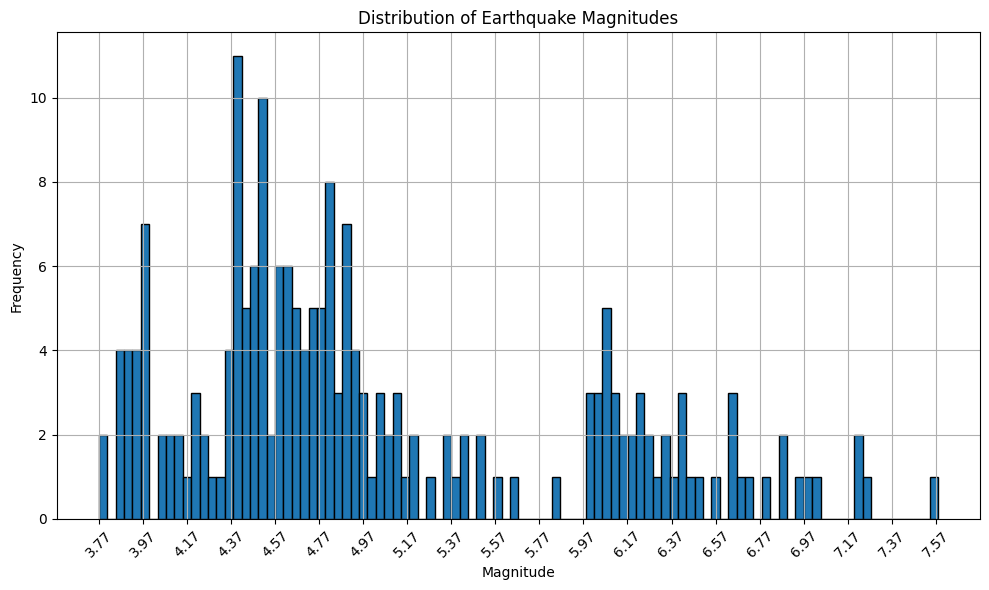

In [ ]:
magnitudes = [event['source_magnitude'] for event in combined_event_params]

# Plotting the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(magnitudes, bins=100, edgecolor='black')

# Add more labels to the bottom with increments of 0.2
min_bin, max_bin = bins[0], bins[-1]
bin_ticks = np.arange(min_bin, max_bin, 0.2)
plt.xticks(bin_ticks, [f'{round(tick, 2)}' for tick in bin_ticks], rotation=45)

plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

##Writing Data


In [ ]:
def seisbench_write_gisola(catalog,trace_params,event_params, gisola):
    base_path = Path("./selected")
    metadata_path = base_path / "metadata.csv"
    waveforms_path = base_path / "waveforms.hdf5"
    with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

        # Define data format
        writer.data_format = {
            "dimension_order": "CW",
            "component_order": "ZNE",
            "measurement": "velocity",
            "unit": "counts",
            "instrument_response": "not restituted",
        }
        event_counter = 0
        for i, event in enumerate(catalog):
        # for pick in pick_catalog:
            for j, pick in enumerate(event):
                stream = pick
                actual_t_start, data, _ = sbu.stream_to_array(
                    stream,
                    component_order=writer.data_format["component_order"],
                )
                sampling_rate = 100
                trace_params[i][j]["trace_sampling_rate_hz"] = sampling_rate
                trace_params[i][j]["predicted_magnitude_gisola"] = gisola[i]['magnitude']
                writer.add_trace({**event_params[i], **trace_params[i][j]}, data)

In [ ]:
seisbench_write_gisola(selected_catalog, selected_trace_params, selected_event_params, selected_predict_gisola)

Traces converted: 315it [00:00, 801.31it/s]


In [ ]:
base_path = Path("./selected")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
data_selected = sbd.WaveformDataset(base_path, sampling_rate=100)

2024-06-15 08:42:05,411 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [ ]:
def seisbench_write(catalog,trace_params,event_params):
    base_path = Path(".")
    metadata_path = base_path / "metadata.csv"
    waveforms_path = base_path / "waveforms.hdf5"
    with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

        # Define data format
        writer.data_format = {
            "dimension_order": "CW",
            "component_order": "ZNE",
            "measurement": "velocity",
            "unit": "counts",
            "instrument_response": "not restituted",
        }
        event_counter = 0
        for i, event in enumerate(catalog):
        # for pick in pick_catalog:
            for j, pick in enumerate(event):
                stream = pick
                actual_t_start, data, _ = sbu.stream_to_array(
                    stream,
                    component_order=writer.data_format["component_order"],
                )
                sampling_rate = 100
                trace_params[i][j]["trace_sampling_rate_hz"] = sampling_rate
                writer.add_trace({**event_params[i], **trace_params[i][j]}, data)

In [ ]:
seisbench_write(combined_catalog, combined_trace_params, combined_event_params)

Traces converted: 1894it [00:00, 1898.98it/s]


In [ ]:
base_path = Path(".")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
data_combined = sbd.WaveformDataset(base_path, sampling_rate=100)

2024-06-19 02:20:20,204 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [ ]:
data_combined.metadata

,index,source_id,source_origin_time,source_origin_uncertainty_sec,source_latitude_deg,source_latitude_uncertainty_km,source_longitude_deg,source_longitude_uncertainty_km,source_depth_km,source_magnitude,...,trace_S_arrival_sample,trace_S_status,trace_pP_arrival_time,trace_pP_arrival_sample,trace_pP_status,trace_sP_arrival_time,trace_sP_arrival_sample,trace_sP_status,trace_chunk,trace_component_order
0,0,smi:org.gfz-potsdam.de/geofon/gfz2016eslv,2016-03-08T00:33:03.570000Z,0.32,-6.554,3.84,130.145,5.78,110.8,3.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
1,1,smi:org.gfz-potsdam.de/geofon/gfz2016eslv,2016-03-08T00:33:03.570000Z,0.32,-6.554,3.84,130.145,5.78,110.8,3.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
2,2,smi:org.gfz-potsdam.de/geofon/gfz2016eslv,2016-03-08T00:33:03.570000Z,0.32,-6.554,3.84,130.145,5.78,110.8,3.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
3,3,smi:org.gfz-potsdam.de/geofon/gfz2016gbnb,2016-03-27T04:57:09.230000Z,0.20,-7.439,3.76,121.183,5.36,545.2,3.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
4,4,smi:org.gfz-potsdam.de/geofon/gfz2016gbnb,2016-03-27T04:57:09.230000Z,0.20,-7.439,3.76,121.183,5.36,545.2,3.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,1889,smi:org.gfz-potsdam.de/geofon/gfz2023qwer,2023-08-28T19:55:31.750000Z,0.04,-6.935,0.78,116.588,0.73,514.4,7.03,...,1199.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
1890,1890,smi:org.gfz-potsdam.de/geofon/gfz2023qwer,2023-08-28T19:55:31.750000Z,0.04,-6.935,0.78,116.588,0.73,514.4,7.03,...,1200.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
1891,1891,smi:org.gfz-potsdam.de/geofon/gfz2023qwer,2023-08-28T19:55:31.750000Z,0.04,-6.935,0.78,116.588,0.73,514.4,7.03,...,1200.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE
1892,1892,smi:org.gfz-potsdam.de/geofon/gfz2023qwer,2023-08-28T19:55:31.750000Z,0.04,-6.935,0.78,116.588,0.73,514.4,7.03,...,1199.0,manual,NaN,NaN,NaN,NaN,NaN,NaN,,ZNE


#### Denoising Waveform Data

In [ ]:
model_denoiser = sbm.DeepDenoiser.from_pretrained("original")

In [ ]:
def denoised_catalog(catalog):
    denoised_catalog = [[] for _ in catalog]

    event_counter = 0
    for event in catalog:
        # Initialize the inner list for each event
        denoised_catalog[event_counter] = []
        for pick in event:
            denoised = model_denoiser.annotate(pick)
            # Append the denoised pick to the current event's list
            denoised_catalog[event_counter].append(denoised)
        event_counter += 1
    return denoised_catalog

In [ ]:
denoised = denoised_catalog(combined_catalog)

In [ ]:
data_geofon = sbd.GEOFON(force=True, sampling_rate=100)

2024-06-15 11:56:25,314 | seisbench | WARNING | Dataset GEOFON not in cache.
2024-06-15 11:56:25,316 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2024-06-15 12:29:19,392 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


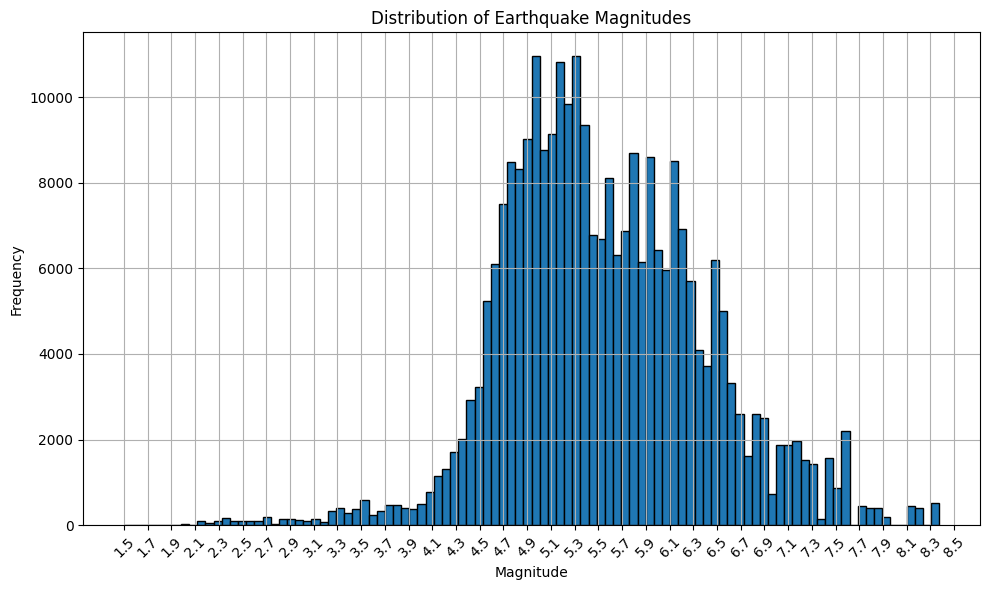

In [ ]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10, 6))
plt.hist(data_geofon['source_magnitude'], bins=100, edgecolor='black')
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

# Add x-axis labels at 0.2 intervals
min_magnitude = data_geofon['source_magnitude'].min()
max_magnitude = data_geofon['source_magnitude'].max()
x_ticks = np.arange(min_magnitude, max_magnitude + 0.2, 0.2)
plt.xticks(x_ticks, rotation=45)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow as tf
import pandas as pd
#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)
path = '/content/drive/My Drive/EEWS/model.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model_original = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model_original.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes_original = [layer.input_shape for layer in model_original.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")


path = '/content/drive/My Drive/EEWS/model_029.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model_retrain = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model_retrain.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes_retrain = [layer.input_shape for layer in model_retrain.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_1 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 750, 32)           0         
                                                           

##Converting Data


In [ ]:
from keras.models import Model, Sequential
import keras
import locale
import os
import matplotlib

import matplotlib.pyplot as plt
from tqdm import tqdm

from os import listdir, walk
from os.path import isfile, join, isdir
import pickle
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from datetime import datetime
from datetime import timedelta
import os.path
from keras import Sequential
from keras.layers import Dense
import h5py
import tensorflow as tf
from keras import backend as K
import pandas as pd
import csv



def datat_reader(data, file_list):
    X = np.zeros([len(file_list), 3000, 3])
    Y = np.zeros([len(file_list), 1])
    for c, evi in enumerate(file_list):
        dataset = data.get_waveforms(c)
        data_np = np.array(dataset)
        data_np = data_np.T
        data_np[:, [0, 2]] = data_np[:, [2, 0]]
        if not pd.isna(data.metadata.loc[c,'trace_P_arrival_sample']):
          spt = int(data.metadata.loc[c,'trace_P_arrival_sample'])
          mag = round(float(data.metadata.loc[c,'source_magnitude']), 2)
          start_idx = spt - 100
          end_idx = spt + 2900
          try:
            dshort = data_np[start_idx:end_idx, :]
            X[c, :, :] = dshort
            Y[c, 0] = mag
          except:
            pass

    return X, Y

In [ ]:
df = data_combined.metadata
test = df.trace_name.tolist()
x_test, y_test = datat_reader(data_combined, test)

# df_selected = data_selected.metadata
# test_selected = df_selected.trace_name.tolist()
# x_test_selected , y_test_selected  = datat_reader(data_selected, test_selected)

In [ ]:
from keras.layers import add, ConvLSTM2D, Reshape, Dense, AveragePooling2D, Input, Conv2DTranspose, TimeDistributed, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import add, Reshape, Dense, Input, TimeDistributed, Dropout, Activation, LSTM, Conv1D, Cropping1D
from keras.layers import MaxPooling1D, UpSampling1D, Cropping1D, SpatialDropout1D, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.optimizers import Adam
import locale
import os
import matplotlib

epochs_number = 200
bach_size = 256

drop_rate = 0.2

filters = [32, 64, 96, 128, 256]

inp1 = Input(shape=(3000, 3), name='input_layer')

e = Conv1D(filters[1], 3, padding = 'same')(inp1)
e = Dropout(drop_rate)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Conv1D(filters[0], 3, padding = 'same')(e)
e = Dropout(drop_rate)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Bidirectional(LSTM(100, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)

e = Dense(2)(e)
o = Activation('linear', name='output_layer')(e)

model = Model(inputs=[inp1], outputs=o)


#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)

model.compile(optimizer='Adam', loss=customLoss)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown= 0,
                                patience= 4,
                                min_lr=0.5e-6)
save_dir ='/content'
model_name = 'model'
m_name = str(model_name)+'_{epoch:03d}.h5'
filepath = os.path.join(save_dir, m_name)

early_stopping_monitor = EarlyStopping(monitor= 'loss', patience = 5)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='loss',
                             mode = 'auto',
                             verbose=1,
                             save_best_only=True)

class PrintSomeValues(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print(f'y_test[0:1] = {y_test[0:1]}.')
        print(f'pred = {self.model.predict(x_test[0:1])}.')

psv = PrintSomeValues()

callbacks = [lr_reducer, early_stopping_monitor, checkpoint, psv]

history = model.fit(x_train, y_train, epochs=epochs_number, validation_split=0.2, batch_size=bach_size, callbacks = callbacks)

y_test[0:1] = [[5.2]].
1/1 [==============================] - 1s 862ms/step
pred = [[-0.02860636 -1.5917555 ]].
Epoch 1/200
861/861 [==============================] - ETA: 0s - loss: 0.5044
Epoch 1: loss improved from inf to 0.50444, saving model to /content/model_001.h5
861/861 [==============================] - 34s 35ms/step - loss: 0.5044 - val_loss: nan - lr: 0.0010
y_test[0:1] = [[5.2]].
1/1 [==============================] - 0s 24ms/step
pred = [[5.3657837  0.01286776]].
Epoch 2/200
  1/861 [..............................] - ETA: 21s - loss: 0.2875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


860/861 [============================>.] - ETA: 0s - loss: 0.3267
Epoch 2: loss improved from 0.50444 to 0.32664, saving model to /content/model_002.h5
861/861 [==============================] - 24s 28ms/step - loss: 0.3266 - val_loss: nan - lr: 0.0010
y_test[0:1] = [[5.2]].
1/1 [==============================] - 0s 24ms/step
pred = [[ 5.6299067  -0.48967582]].
Epoch 3/200
860/861 [============================>.] - ETA: 0s - loss: 0.3162
Epoch 3: loss improved from 0.32664 to 0.31622, saving model to /content/model_003.h5
861/861 [==============================] - 24s 28ms/step - loss: 0.3162 - val_loss: nan - lr: 0.0010
y_test[0:1] = [[5.2]].
1/1 [==============================] - 0s 24ms/step
pred = [[ 5.575011   -0.60419655]].
Epoch 4/200
860/861 [============================>.] - ETA: 0s - loss: 0.3075
Epoch 4: loss improved from 0.31622 to 0.30751, saving model to /content/model_004.h5
861/861 [==============================] - 25s 28ms/step - loss: 0.3075 - val_loss: nan - lr: 0.

In [ ]:
from keras.layers import add, ConvLSTM2D, Reshape, Dense, AveragePooling2D, Input, Conv2DTranspose, TimeDistributed, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import add, Reshape, Dense, Input, TimeDistributed, Dropout, Activation, LSTM, Conv1D, Cropping1D
from keras.layers import MaxPooling1D, UpSampling1D, Cropping1D, SpatialDropout1D, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.optimizers import Adam
import locale
import os
import matplotlib

epochs_number = 200
bach_size = 256

drop_rate = 0.2

filters = [32, 64, 96, 128, 256]

inp1 = Input(shape=(3000, 3), name='input_layer')

e = Conv1D(filters[1], 3, padding = 'same')(inp1)
e = Dropout(drop_rate)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Conv1D(filters[0], 3, padding = 'same')(e)
e = Dropout(drop_rate)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Bidirectional(LSTM(100, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)

e = Dense(2)(e)
o = Activation('linear', name='output_layer')(e)

model = Model(inputs=[inp1], outputs=o)


#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)

model.compile(optimizer='Adam', loss=customLoss)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown= 0,
                                patience= 4,
                                min_lr=0.5e-6)
save_dir ='/content'
model_name = 'model'
m_name = str(model_name)+'_{epoch:03d}.h5'
filepath = os.path.join(save_dir, m_name)

early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 5)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             mode = 'auto',
                             verbose=1,
                             save_best_only=True)

class PrintSomeValues(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print(f'y_test[0:1] = {y_test[0:1]}.')
        print(f'pred = {self.model.predict(x_test[0:1])}.')

psv = PrintSomeValues()

callbacks = [lr_reducer, early_stopping_monitor, checkpoint, psv]

history = model.fit(x_test, y_test, epochs=epochs_number, validation_split=0.2, batch_size=bach_size, callbacks = callbacks)

y_test[0:1] = [[3.98]].
1/1 [==============================] - 1s 1s/step
pred = [[ 0.22225603 -0.3377293 ]].
Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: 8.0054
Epoch 1: val_loss improved from inf to 3.16883, saving model to /content/model_001.h5
6/6 [==============================] - 16s 2s/step - loss: 8.0054 - val_loss: 3.1688 - lr: 0.0010
y_test[0:1] = [[3.98]].


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 56ms/step
pred = [[1.4439342 2.9672961]].
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: 2.1357
Epoch 2: val_loss improved from 3.16883 to 2.32141, saving model to /content/model_002.h5
6/6 [==============================] - 9s 2s/step - loss: 2.1357 - val_loss: 2.3214 - lr: 0.0010
y_test[0:1] = [[3.98]].
1/1 [==============================] - 0s 107ms/step
pred = [[2.768961 3.054937]].
Epoch 3/200
6/6 [==============================] - ETA: 0s - loss: 2.0699
Epoch 3: val_loss improved from 2.32141 to 2.25114, saving model to /content/model_003.h5
6/6 [==============================] - 10s 2s/step - loss: 2.0699 - val_loss: 2.2511 - lr: 0.0010
y_test[0:1] = [[3.98]].
1/1 [==============================] - 0s 139ms/step
pred = [[3.067847  3.0033703]].
Epoch 4/200
6/6 [==============================] - ETA: 0s - loss: 2.0682
Epoch 4: val_loss improved from 2.25114 to 2.18311, saving model to /content/model_004.h5
6/6 [========

##Predicting Selected Data

In [ ]:
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow as tf
import pandas as pd
#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)
path = '/content/drive/My Drive/EEWS/model.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_1 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 750, 32)           0         
                                                           

In [ ]:
class KerasDropoutPrediction(object):
    def __init__(self, model):
        self.model = model

    def predict(self, x, n_iter=1):
        predM = []
        auM = []

        for itr in range(n_iter):
            print('Prediction: #'+ str(itr+1))
            r = model.predict(x, batch_size=bach_size, verbose=0)

            pred = r[:, 0]
            au = r[:, 1]
            predM.append(pred.T)
            auM.append(au.T)

        predM = np.array(predM).reshape(n_iter,len(predM[0]))
        auM = np.array(auM).reshape(n_iter, len(auM[0]))

        yhat_mean = predM.mean(axis=0)
        yhat_squared_mean = np.square(predM).mean(axis=0)

        sigma_squared = 10**(auM)
        sigma_squared_mean = sigma_squared.mean(axis=0)

        ep_unc = predM.std(axis=0)

        combibed = yhat_squared_mean - np.square(yhat_mean)+ sigma_squared_mean

        return yhat_mean, sigma_squared_mean, ep_unc, combibed

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

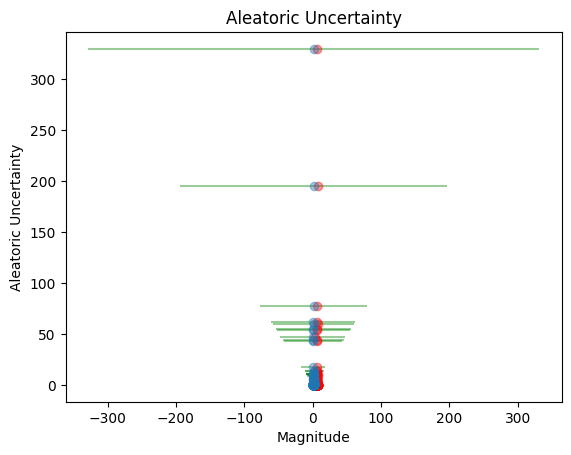

In [ ]:
bach_size = 256

monte_carlo_sampling = 50


kdp_original = KerasDropoutPrediction(model)
predic_original, al_unc_original, ep_unc_original, comb_original = kdp_original.predict(x_test_selected , monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_original, al_unc_original, xerr= al_unc_original, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_original, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
path = '/content/drive/My Drive/EEWS/model_029.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_6 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_7 (Dropout)         (None, 750, 32)           0         
                                                           

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

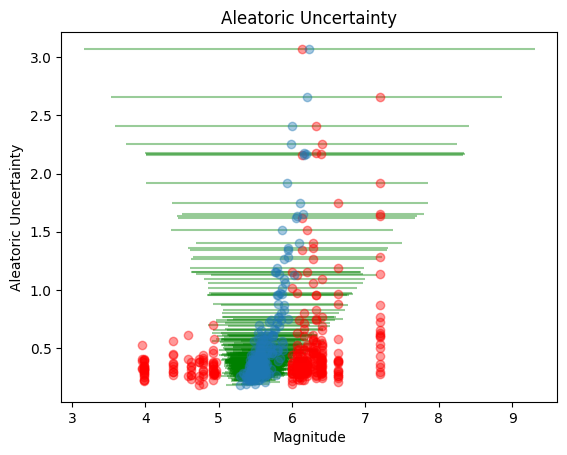

In [ ]:
kdp_retrain = KerasDropoutPrediction(model)
predic_retrain, al_unc_retrain, ep_unc_retrain, comb_retrain = kdp_retrain.predict(x_test_selected , monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_retrain, al_unc_retrain, xerr= al_unc_retrain, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_retrain, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
base_path = Path("./results")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    counter = 0
    for i, event in enumerate(selected_catalog):
    # for pick in pick_catalog:
        for j, pick in enumerate(event):
            stream = pick
            actual_t_start, data, _ = sbu.stream_to_array(
                stream,
                component_order=writer.data_format["component_order"],
            )
            sampling_rate = 100
            selected_trace_params[i][j]["trace_sampling_rate_hz"] = sampling_rate
            selected_trace_params[i][j]["predicted_magnitude_gisola"] = selected_predict_gisola[i]['magnitude']
            selected_trace_params[i][j]["predicted_magnitude_magnet"] = predic_original[counter]
            selected_trace_params[i][j]["predicted_magnitude_magnet_retrain"] = predic_retrain[counter]
            writer.add_trace({**selected_event_params[i], **selected_trace_params[i][j]}, data)
            counter+=1
data = sbd.WaveformDataset(base_path, sampling_rate=100)


Traces converted: 315it [00:00, 662.89it/s] 
2024-06-15 08:17:10,193 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


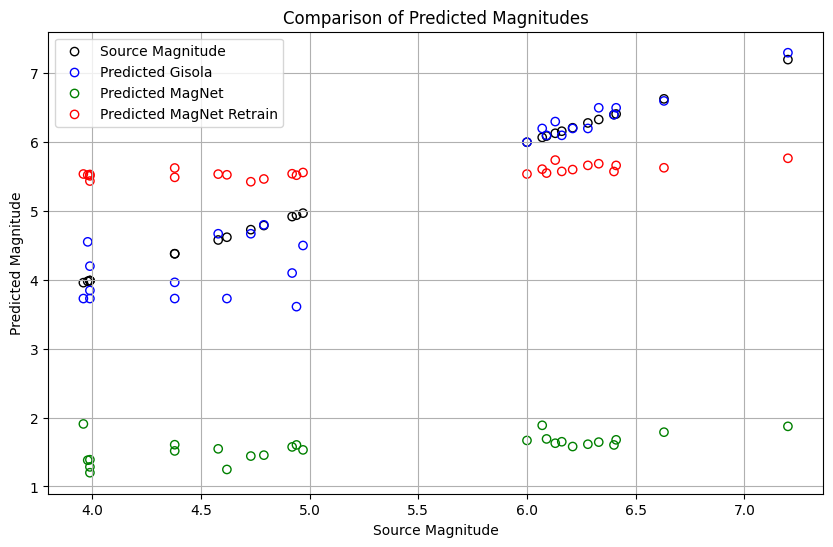

In [ ]:
# Convert predicted_magnitude_gisola to Mw if source_magnitude_type is mb
df_selected = data.metadata


# Group by source_origin_id and calculate the mean for the relevant columns
df_mean = df_selected.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()

# Merge the mean values back to the original DataFrame
df_selected = df_selected.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_selected = df_selected.drop_duplicates(subset='source_id').reset_index(drop=True)
df_selected = df_selected.merge(df_mean, on='source_id')

# Convert predicted_magnitude_gisola to Mw if source_magnitude_type is mb
def convert_mb_to_mw(row):
    if row['source_magnitude_type'] == 'mb':
        return (row['predicted_magnitude_gisola'] - 1.03) / 0.85
    return row['predicted_magnitude_gisola']

df_selected['predicted_magnitude_gisola'] = df_selected.apply(convert_mb_to_mw, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['source_magnitude'], df_selected['source_magnitude'], label='Source Magnitude', facecolors='none', edgecolors='black')
plt.scatter(df_selected['source_magnitude'], df_selected['predicted_magnitude_gisola'], label='Predicted Gisola', facecolors='none', edgecolors='blue')
plt.scatter(df_selected['source_magnitude'], df_selected['predicted_magnitude_magnet'], label='Predicted MagNet', facecolors='none', edgecolors='green')
plt.scatter(df_selected['source_magnitude'], df_selected['predicted_magnitude_magnet_retrain'], label='Predicted MagNet Retrain', facecolors='none', edgecolors='red')

# Add labels and title
plt.xlabel('Source Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Comparison of Predicted Magnitudes')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to categorize magnitudes
def categorize_magnitude(magnitude):
    if magnitude < 4:
        return 'low'
    elif 4 <= magnitude < 6:
        return 'mid'
    else:
        return 'high'

# Apply the categorization function
df_selected['magnitude_category'] = df_selected['source_magnitude'].apply(categorize_magnitude)

# Calculate the average of the relevant columns
df_selected_mean = df_selected.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()
df_selected = df_selected.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_selected = df_selected.drop_duplicates(subset='source_id').reset_index(drop=True)
df_selected = df_selected.merge(df_selected_mean, on='source_id')

# Convert predicted_magnitude_gisola to Mw if source_magnitude_type is mb
def convert_mb_to_mw(row):
    if row['source_magnitude_type'] == 'mb':
        return (row['predicted_magnitude_gisola'] - 1.03) / 0.85
    return row['predicted_magnitude_gisola']

df_selected['predicted_magnitude_gisola'] = df_selected.apply(convert_mb_to_mw, axis=1)

# Function to calculate metrics
def calculate_metrics(df_selected, source_col, pred_col):
    mae = mean_absolute_error(df_selected[source_col], df_selected[pred_col])
    mse = mean_squared_error(df_selected[source_col], df_selected[pred_col])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Dictionary to store metrics
metrics = {
    'low': {},
    'mid': {},
    'high': {}
}

# Calculate metrics for each category and each prediction
for category in ['low', 'mid', 'high']:
    df_selected_category = df_selected[df_selected['magnitude_category'] == category]
    metrics[category]['gisola'] = calculate_metrics(df_selected_category, 'source_magnitude', 'predicted_magnitude_gisola')
    metrics[category]['magnet'] = calculate_metrics(df_selected_category, 'source_magnitude', 'predicted_magnitude_magnet')
    metrics[category]['magnet_retrain'] = calculate_metrics(df_selected_category, 'source_magnitude', 'predicted_magnitude_magnet_retrain')

# Print the metrics
for category in metrics:
    print(f"Category: {category}")
    for model in metrics[category]:
        mae, mse, rmse = metrics[category][model]
        print(f"{model} -> MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}")
    print("\n")

Category: low
gisola -> MAE: 0.283, MSE: 0.103, RMSE: 0.321
magnet -> MAE: 2.542, MSE: 6.530, RMSE: 2.555
magnet_retrain -> MAE: 1.525, MSE: 2.328, RMSE: 1.526


Category: mid
gisola -> MAE: 0.526, MSE: 0.451, RMSE: 0.672
magnet -> MAE: 3.205, MSE: 10.321, RMSE: 3.213
magnet_retrain -> MAE: 0.820, MSE: 0.726, RMSE: 0.852


Category: high
gisola -> MAE: 0.071, MSE: 0.009, RMSE: 0.093
magnet -> MAE: 4.635, MSE: 21.559, RMSE: 4.643
magnet_retrain -> MAE: 0.692, MSE: 0.555, RMSE: 0.745




In [ ]:
df_selected['predicted_magnitude_gisola']['source_magnitude']

KeyError: ('source_magnitude', 'predicted_magnitude_gisola')

##Predicting Combined Data


In [ ]:
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow as tf
import pandas as pd
#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)
path = '/content/drive/My Drive/EEWS/model.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_1 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 750, 32)           0         
                                                           

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

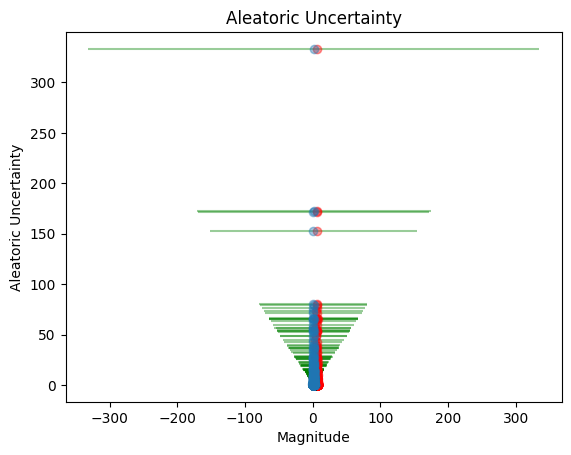

In [ ]:
kdp_original_combined = KerasDropoutPrediction(model)
monte_carlo_sampling = 50
bach_size = 256
predic_original_combined, al_unc_original_combined, ep_unc_original_combined, comb_original_combined = kdp_original_combined.predict(x_test, monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_original_combined, al_unc_original_combined, xerr= al_unc_original_combined, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_original_combined, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
path = '/content/drive/My Drive/EEWS/model_029.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_6 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_7 (Dropout)         (None, 750, 32)           0         
                                                           

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

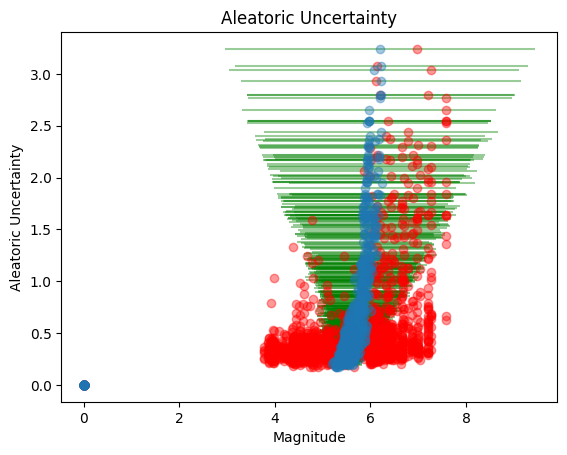

In [ ]:
kdp_retrain_combined = KerasDropoutPrediction(model)
predic_retrain_combined, al_unc_retrain_combined, ep_unc_retrain_combined, comb_retrain_combined = kdp_retrain_combined.predict(x_test, monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_retrain_combined, al_unc_retrain_combined, xerr= al_unc_retrain_combined, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_retrain_combined, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
base_path = Path("./results/combined")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    counter = 0
    for i, event in enumerate(combined_catalog):
    # for pick in pick_catalog:
        for j, pick in enumerate(event):
            stream = pick
            actual_t_start, data, _ = sbu.stream_to_array(
                stream,
                component_order=writer.data_format["component_order"],
            )
            sampling_rate = 100
            combined_trace_params[i][j]["trace_sampling_rate_hz"] = sampling_rate
            combined_trace_params[i][j]["predicted_magnitude_magnet"] = predic_original_combined[counter]
            combined_trace_params[i][j]["predicted_magnitude_magnet_retrain"] = predic_retrain_combined[counter]
            writer.add_trace({**combined_event_params[i], **combined_trace_params[i][j]}, data)
            counter+=1
data = sbd.WaveformDataset(base_path, sampling_rate=100)


Traces converted: 1894it [00:01, 1552.73it/s]
2024-06-19 02:27:32,698 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [ ]:
print(len(data))

1894


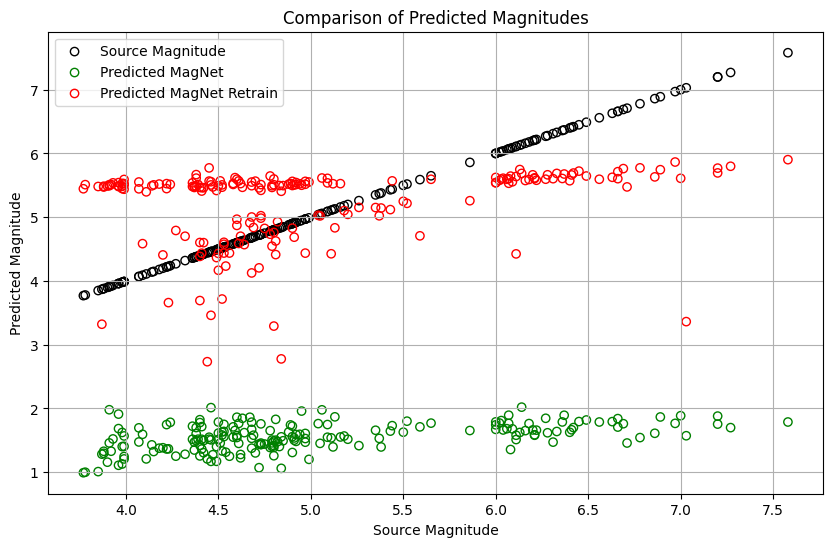

In [ ]:
df_combined = data.metadata


# Group by source_origin_id and calculate the mean for the relevant columns
df_mean = df_combined.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()

# Merge the mean values back to the original DataFrame
df_combined = df_combined.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_combined = df_combined.drop_duplicates(subset='source_id').reset_index(drop=True)
df_combined = df_combined.merge(df_mean, on='source_id')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['source_magnitude'], df_combined['source_magnitude'], label='Source Magnitude', facecolors='none', edgecolors='black')
plt.scatter(df_combined['source_magnitude'], df_combined['predicted_magnitude_magnet'], label='Predicted MagNet', facecolors='none', edgecolors='green')
plt.scatter(df_combined['source_magnitude'], df_combined['predicted_magnitude_magnet_retrain'], label='Predicted MagNet Retrain', facecolors='none', edgecolors='red')

# Add labels and title
plt.xlabel('Source Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Comparison of Predicted Magnitudes')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to categorize magnitudes
def categorize_magnitude(magnitude):
    if magnitude < 4:
        return 'low'
    elif 4 <= magnitude < 6:
        return 'mid'
    else:
        return 'high'

# Apply the categorization function
df_combined['magnitude_category'] = df_combined['source_magnitude'].apply(categorize_magnitude)

# Calculate the average of the relevant columns
df_combined_mean = df_combined.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()
df_combined = df_combined.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_combined = df_combined.drop_duplicates(subset='source_id').reset_index(drop=True)
df_combined = df_combined.merge(df_combined_mean, on='source_id')


# Apply the categorization function
df_combined['magnitude_category'] = df_combined['source_magnitude'].apply(categorize_magnitude)

# Calculate the average of the relevant columns
df_combined_mean = df_combined.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()
df_combined = df_combined.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_combined = df_combined.drop_duplicates(subset='source_id').reset_index(drop=True)
df_combined = df_combined.merge(df_combined_mean, on='source_id')

# Function to calculate metrics
def calculate_metrics(df_combined, source_col, pred_col):
    mae = mean_absolute_error(df_combined[source_col], df_combined[pred_col])
    mse = mean_squared_error(df_combined[source_col], df_combined[pred_col])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Dictionary to store metrics
metrics = {
    'low': {},
    'mid': {},
    'high': {},
    'all': {}
}

# Calculate metrics for each category and each prediction
for category in ['low', 'mid', 'high', 'all']:
    if category == 'all':
        df_combined_category = df_combined
    else:
        df_combined_category = df_combined[df_combined['magnitude_category'] == category]
    metrics[category]['magnet'] = calculate_metrics(df_combined_category, 'source_magnitude', 'predicted_magnitude_magnet')
    metrics[category]['magnet_retrain'] = calculate_metrics(df_combined_category, 'source_magnitude', 'predicted_magnitude_magnet_retrain')

# Print the metrics
for category in metrics:
    print(f"Category: {category}")
    for model in metrics[category]:
        mae, mse, rmse = metrics[category][model]
        print(f"{model} -> MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}")
    print("\n")

Category: low
magnet -> MAE: 2.558, MSE: 6.606, RMSE: 2.570
magnet_retrain -> MAE: 1.525, MSE: 2.377, RMSE: 1.542


Category: mid
magnet -> MAE: 3.173, MSE: 10.201, RMSE: 3.194
magnet_retrain -> MAE: 0.639, MSE: 0.601, RMSE: 0.775


Category: high
magnet -> MAE: 4.726, MSE: 22.489, RMSE: 4.742
magnet_retrain -> MAE: 0.860, MSE: 1.035, RMSE: 1.017


Category: all
magnet -> MAE: 3.481, MSE: 12.773, RMSE: 3.574
magnet_retrain -> MAE: 0.785, MSE: 0.892, RMSE: 0.944




##Predicting Denoised Data

In [ ]:
seisbench_write(denoised, combined_trace_params, combined_event_params)
base_path = Path(".")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
data_denoised = sbd.WaveformDataset(base_path, sampling_rate=100)

Traces converted: 1894it [00:02, 774.58it/s] 
2024-06-15 11:41:48,038 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [ ]:
df_denoised = data_denoised.metadata
test_denoised = df_denoised.trace_name.tolist()
x_test_denoised , actual_mag_denoised , y_test_denoised  = datat_reader(data_denoised, test_denoised)

In [ ]:
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow as tf
import pandas as pd
#costom loss for calculating aleatoric uncertainty
def customLoss(yTrue, yPred):
    y_hat = K.reshape(yPred[:, 0], [-1, 1])
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)
path = '/content/drive/My Drive/EEWS/model.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_1 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_2 (Dropout)         (None, 750, 32)           0         
                                                           

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

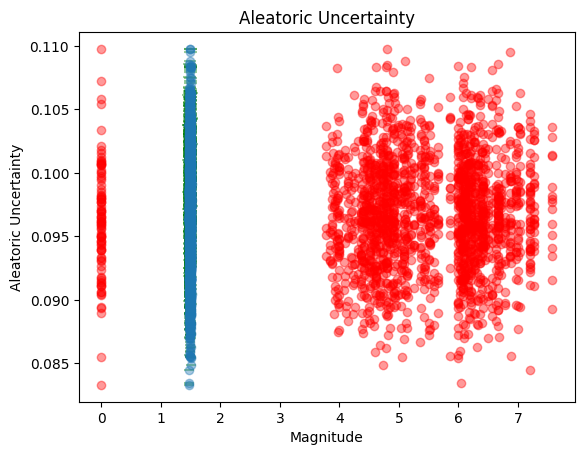

In [ ]:
kdp_original_denoised = KerasDropoutPrediction(model)
predic_original_denoised, al_unc_original_denoised, ep_unc_original_denoised, comb_original_denoised = kdp_original_denoised.predict(x_test_denoised, monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_original_denoised, al_unc_original_denoised, xerr= al_unc_original_denoised, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_original_denoised, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
path = '/content/drive/My Drive/EEWS/model_029.h5'
# Replace 'path/to/your/model.h5' with the actual path to your H5 model file
model = load_model(path, custom_objects={'customLoss': customLoss})

# Print the summary of the model to see input and output shapes
model.summary()

# Alternatively, you can inspect the input shape specifically
input_shapes = [layer.input_shape for layer in model.layers if layer.input is not None]
print(f"Input shapes of the model: {input_shapes}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3000, 3)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3000, 64)          640       
                                                                 
 dropout_6 (Dropout)         (None, 3000, 64)          0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 750, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 dropout_7 (Dropout)         (None, 750, 32)           0         
                                                           

Prediction: #1
Prediction: #2
Prediction: #3
Prediction: #4
Prediction: #5
Prediction: #6
Prediction: #7
Prediction: #8
Prediction: #9
Prediction: #10
Prediction: #11
Prediction: #12
Prediction: #13
Prediction: #14
Prediction: #15
Prediction: #16
Prediction: #17
Prediction: #18
Prediction: #19
Prediction: #20
Prediction: #21
Prediction: #22
Prediction: #23
Prediction: #24
Prediction: #25
Prediction: #26
Prediction: #27
Prediction: #28
Prediction: #29
Prediction: #30
Prediction: #31
Prediction: #32
Prediction: #33
Prediction: #34
Prediction: #35
Prediction: #36
Prediction: #37
Prediction: #38
Prediction: #39
Prediction: #40
Prediction: #41
Prediction: #42
Prediction: #43
Prediction: #44
Prediction: #45
Prediction: #46
Prediction: #47
Prediction: #48
Prediction: #49
Prediction: #50


Text(0.5, 1.0, 'Aleatoric Uncertainty')

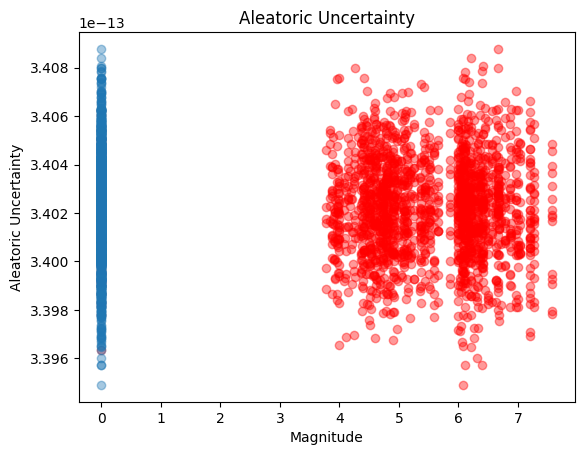

In [ ]:
kdp_retrain_denoised = KerasDropoutPrediction(model)
predic_retrain_denoised, al_unc_retrain_denoised, ep_unc_retrain_denoised, comb_retrain_denoised = kdp_retrain_denoised.predict(x_test_denoised, monte_carlo_sampling)


fig1 = plt.figure()
plt.errorbar(predic_retrain_denoised, al_unc_retrain_denoised, xerr= al_unc_retrain_denoised, fmt='o', alpha=0.4, ecolor='g', capthick=2)
plt.plot(y_test, al_unc_retrain_denoised, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Aleatoric Uncertainty')
plt.title('Aleatoric Uncertainty')

In [ ]:
base_path = Path("./results/denoised")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    counter = 0
    for i, event in enumerate(denoised):
    # for pick in pick_catalog:
        for j, pick in enumerate(event):
            stream = pick
            actual_t_start, data, _ = sbu.stream_to_array(
                stream,
                component_order=writer.data_format["component_order"],
            )
            sampling_rate = 100
            combined_trace_params[i][j]["trace_sampling_rate_hz"] = sampling_rate
            combined_trace_params[i][j]["predicted_magnitude_magnet"] = predic_original_denoised[counter]
            combined_trace_params[i][j]["predicted_magnitude_magnet_retrain"] = predic_retrain_denoised[counter]
            writer.add_trace({**combined_event_params[i], **combined_trace_params[i][j]}, data)
            counter+=1
data = sbd.WaveformDataset(base_path, sampling_rate=100)


Traces converted: 1894it [00:02, 856.03it/s] 
2024-06-15 11:49:38,948 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


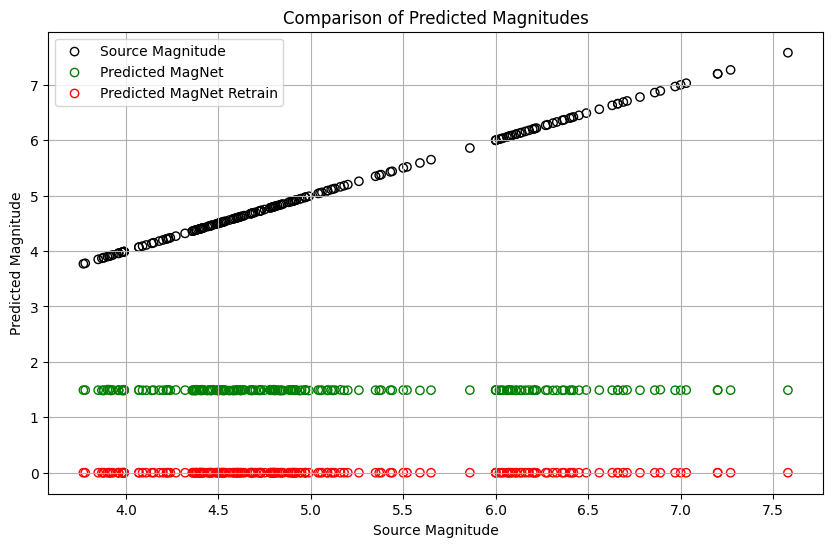

In [ ]:
df_denoised = data.metadata


# Group by source_origin_id and calculate the mean for the relevant columns
df_mean = df_denoised.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()

# Merge the mean values back to the original DataFrame
df_denoised = df_denoised.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_denoised = df_denoised.drop_duplicates(subset='source_id').reset_index(drop=True)
df_denoised = df_denoised.merge(df_mean, on='source_id')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_denoised['source_magnitude'], df_denoised['source_magnitude'], label='Source Magnitude', facecolors='none', edgecolors='black')
plt.scatter(df_denoised['source_magnitude'], df_denoised['predicted_magnitude_magnet'], label='Predicted MagNet', facecolors='none', edgecolors='green')
plt.scatter(df_denoised['source_magnitude'], df_denoised['predicted_magnitude_magnet_retrain'], label='Predicted MagNet Retrain', facecolors='none', edgecolors='red')

# Add labels and title
plt.xlabel('Source Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Comparison of Predicted Magnitudes')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to categorize magnitudes
def categorize_magnitude(magnitude):
    if magnitude < 4:
        return 'low'
    elif 4 <= magnitude < 6:
        return 'mid'
    else:
        return 'high'

# Apply the categorization function
df_denoised['magnitude_category'] = df_denoised['source_magnitude'].apply(categorize_magnitude)

# Calculate the average of the relevant columns
df_denoised_mean = df_denoised.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()
df_denoised = df_denoised.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_denoised = df_denoised.drop_duplicates(subset='source_id').reset_index(drop=True)
df_denoised = df_denoised.merge(df_denoised_mean, on='source_id')


# Apply the categorization function
df_denoised['magnitude_category'] = df_denoised['source_magnitude'].apply(categorize_magnitude)

# Calculate the average of the relevant columns
df_denoised_mean = df_denoised.groupby('source_id')[['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain']].mean().reset_index()
df_denoised = df_denoised.drop(columns=['predicted_magnitude_magnet', 'predicted_magnitude_magnet_retrain'])
df_denoised = df_denoised.drop_duplicates(subset='source_id').reset_index(drop=True)
df_denoised = df_denoised.merge(df_denoised_mean, on='source_id')

# Function to calculate metrics
def calculate_metrics(df_denoised, source_col, pred_col):
    mae = mean_absolute_error(df_denoised[source_col], df_denoised[pred_col])
    mse = mean_squared_error(df_denoised[source_col], df_denoised[pred_col])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Dictionary to store metrics
metrics = {
    'low': {},
    'mid': {},
    'high': {},
    'all': {}
}

# Calculate metrics for each category and each prediction
for category in ['low', 'mid', 'high', 'all']:
    if category == 'all':
        df_denoised_category = df_denoised
    else:
        df_denoised_category = df_denoised[df_denoised['magnitude_category'] == category]
    metrics[category]['magnet'] = calculate_metrics(df_denoised_category, 'source_magnitude', 'predicted_magnitude_magnet')
    metrics[category]['magnet_retrain'] = calculate_metrics(df_denoised_category, 'source_magnitude', 'predicted_magnitude_magnet_retrain')

# Print the metrics
for category in metrics:
    print(f"Category: {category}")
    for model in metrics[category]:
        mae, mse, rmse = metrics[category][model]
        print(f"{model} -> MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}")
    print("\n")

Category: low
magnet -> MAE: 2.433, MSE: 5.923, RMSE: 2.434
magnet_retrain -> MAE: 3.923, MSE: 15.394, RMSE: 3.923


Category: mid
magnet -> MAE: 3.214, MSE: 10.458, RMSE: 3.234
magnet_retrain -> MAE: 4.704, MSE: 22.252, RMSE: 4.717


Category: high
magnet -> MAE: 4.946, MSE: 24.619, RMSE: 4.962
magnet_retrain -> MAE: 6.436, MSE: 41.574, RMSE: 6.448


Category: all
magnet -> MAE: 3.548, MSE: 13.380, RMSE: 3.658
magnet_retrain -> MAE: 5.038, MSE: 26.169, RMSE: 5.116


